<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/prototype_model/train_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

필요한 패키지 불러오기

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install konlpy
!pip install transformers-interpret

matplotlib 한글 깨짐 해결

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

mecab 설치

In [ ]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

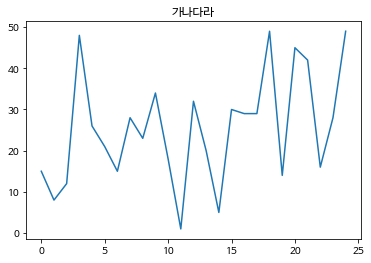

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### TPU 설정 코드

#### 구글 드라이브와 코랩 연결

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/prototype_model')

Mounted at /content/drive


In [3]:
ls

baseline_KLUE_BERT.ipynb     bpe_10000.tmp              연습장.ipynb
baseline_KLUE_RoBERTa.ipynb  bpe_10000_train_spm.model  model/
baseline_KoELECTRA.ipynb     bpe_10000_train_spm.vocab  pred_data/
baseline_KoGPT.ipynb         data/                      submission/
baseline_LSTM.ipynb          eval_dataset/              train_baseline.ipynb


In [6]:
import pandas as pd

tmp = pd.read_csv("./data/sample_data_v3.csv", index_col = [0])
tmp[tmp["class"] != 4].to_csv("./data/no_normal_data_v1.csv")

## 모델 클래스 및 함수 

#### 데이터 로딩 클래스

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

class DataLoad():


  def __init__(self, data_path):
    self.dataset = pd.read_csv(data_path)


  def split(self, split_size):
    X = self.dataset["pre_conversation"]
    Y = self.dataset["class"]
    print(self.dataset.groupby("class").count().iloc[:,0])
    print(self.dataset.head())
    # 전체 데이터의 split_size 비율 만큼은 테스트, 검증 데이터입니다.
    x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = split_size, 
                                                            random_state = 200,
                                                            stratify = Y)
    # 테스트, 검증 데이터의 개수는 1:1의 비율을 가집니다.
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
    print(f"x_train 개수 : {len(x_train)}")
    print(f"y_train 개수 : {len(y_train)}")
    print(f"x_val 개수 : {len(x_val)}")
    print(f"y_val 개수 : {len(y_val)}")
    print(f"x_test 개수 : {len(x_test)}")
    print(f"y_test 개수 : {len(y_test)}")
    print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
    print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
    print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")
    return x_train.tolist(), x_val.tolist(), x_test.tolist(), y_train.tolist(), y_val.tolist(), y_test.tolist()

#### 데이터 증강 클래스

In [8]:
import random
import gensim
from konlpy.tag import Mecab
from tqdm import tqdm

class DataAugmentation:


  def __init__(self, X, Y, word2vec_path):
    self.mecab = Mecab()
    self.word2vec = gensim.models.Word2Vec.load(word2vec_path)
    self.X = X
    self.Y = Y
  
  def sub_rep(self, X, sub_ratio = 0.1):
    # 전체 단어중에서 sub_ratio 만큼만 무작위 선택합니다.
    nouns = list(set(self.mecab.morphs(X)))
    sub_num = int(len(nouns) * sub_ratio)
    sub_list = random.sample(nouns, sub_num)

    # 대체 시킬 단어와 유사한 단어들을 불러옵니다.
    result = []
    for sub in sub_list:
      try:
        result.append((sub, self.word2vec.wv.most_similar(sub)[0]))
      except KeyError:
        pass
    result = list(map(lambda x: (x[0], x[1][0]), result))

    # 무작위 선택된 단어들을 유사한 단어들로 바꿔줍니다.
    for before, after in result:
      X = X.replace(before, after, 1)
    return X

  def sub_rep_dataset(self, sub_ratio = 0.1):
    # 입력 X에 sub_rep 함수 적용합니다.
    new_x = list(tqdm(map(lambda x: self.sub_rep(x, sub_ratio), self.X)))
    # 입력 Y의 값을 복사합니다.
    new_y = self.Y.copy()

    print("훈련 데이터 유의어 대체 증강 완료")
    print(f"증강시킨 데이터 개수 : {len(new_x)}")
    print(f"----데이터 증강 전 데이터 예시 ----\n{self.X[0]}")
    print(f"----데이터 증강 후 데이터 예시 ----\n{new_x[0]}")
    return new_x, new_y

  def label_repeat(self, label_id, num = 1):
    # 특정 레이블 label_id를 num 횟수 만큼 반복
    new_x = []
    new_y = []
    for i in range(num):
      label_index = (np.array(self.Y) == label_id)
      new_x += np.array(self.X)[label_index].tolist()
      new_y += np.array(self.Y)[label_index].tolist()
    
    print("훈련 데이터 특정 레이블 반복 증강 완료")
    print(f"반복되는 레이블 id : {label_id}")
    print(f"반복된 횟수 : {num}")
    return new_x, new_y

#### 기타 함수 

In [78]:
def id2label(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == 0:
    return "협박 대화"
  elif x == 1:
    return "갈취 대화"
  elif x == 2:
    return "직장 내 괴롭힘 대화"
  elif x == 3:
    return "기타 괴롭힘 대화"


def clf_score(y_test, y_pred):
  # 테스트 데이터에서 오분류된 데이터들의 idx를 리스트 타입으로 반환합니다.
  # classification report 
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  print(f"모델이 틀린 데이터 개수 {len(false_list)}개")
  print(classification_report(y_test, y_pred))

  # confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
  conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
  sns.heatmap(conf_matrix, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("pred")
  plt.ylabel("true")
  plt.show()
  return false_list


def evaluate_result(score_list, x_test, y_pred, y_test):
  # 입력, 예측값, 실제값, 레이블별 score로 이루어진 판다스 데이터셋을 반환합니다.
  score_dataset = pd.DataFrame(score_list).add_prefix("label_")
  label_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_test":y_test})
  test_dataset = pd.concat([label_dataset, score_dataset], axis = 1)
  return test_dataset


def false_case_dataset(false_list, x_test, y_test, y_pred, print_example = False):
  # 오분류된 idx에 맞는 입력, 예측값, 실제값을 담은 리스트를 반환합니다.
  false_x_test = [x_test[i] for i in false_list]
  false_y_test = [y_test[i] for i in false_list]
  false_y_pred = [y_pred[i] for i in false_list]

  # 앞서 담은 리스트들을 판다스 데이터프레임 타입으로 변환시킵니다.
  false_dataset = pd.DataFrame({"text":false_x_test, "y_true":false_y_test, "y_pred":false_y_pred})
  # 숫자로된 id를 실제 레이블로 바꾸며 예시는 '0 -> 협박 대화' 입니다.
  false_dataset["y_true"] = false_dataset["y_true"].apply(lambda x : id2label(x))
  false_dataset["y_pred"] = false_dataset["y_pred"].apply(lambda x : id2label(x))

  # 오분류 예제의 내용을 보고 싶으면 print_example argument를 True로 바꿉니다.
  if print_example:
    for i in range(len(false_dataset)):
      sentence, prediction, real =false_dataset.iloc[i, :]
      print(f"예측 분류 : {prediction}")
      print(f"실제 분류 : {real}")
      print(sentence)
      print("\n")
  return false_dataset  


def save_csv(df, path, name):
  try:
    os.mkdir(path)
  except:
    pass
  new_path = os.path.join(path, name)
  df.to_csv(new_path)

#### Huggingface 모델 파이프라인 클래스

In [80]:
import os
import re
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel


class TFGPT2ForSequenceClassification(tf.keras.Model):
  """
  GPT모델은 따로 출력층에 softmax 레이어를 추가해야 합니다.
  """
  def __init__(self, model_name, num_labels):
      super(TFGPT2ForSequenceClassification, self).__init__()
      self.gpt = TFAutoModel.from_pretrained(model_name, 
                                              from_pt=True)
      self.classifier = tf.keras.layers.Dense(num_labels,
                                              kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                              activation='softmax',
                                              name='classifier')

  def call(self, inputs):
      outputs = self.gpt(input_ids=inputs)
      cls_token = outputs[0][:, -1]
      prediction = self.classifier(cls_token)

      return prediction


class TrainPipeline:
  def __init__(self, model_path, num_labels, batch_size = 16, epochs = 1):
    """
    Args:
      - model_path : Hugginface에서 사전학습된 모델들의 주소 str값을 받습니다.
      - num_labels : 분류되는 클래스의 개수 int값을 받습니다.
      - batch_size : 배치마다 들어가는 데이터의 개수 int값을 받습니다.
      - epochs : 모델이 학습하는 에폭 수 int값을 받습니다.
    Desc:
      - 데이터셋 구축, 모델 훈련, 저장, 검증의 과정을 거치는 훈련 파이프라인
    """
    self.model_path = model_path
    self.batch_size = batch_size
    self.epochs = epochs
    self.num_labels = num_labels
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_path,
                                                   bos_token='</s>', 
                                                   eos_token='</s>', 
                                                   pad_token='<pad>')
    self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                      num_labels = self.num_labels,
                                                                      from_pt=True)
    # https://stackoverflow.com/questions/69191305/how-to-add-new-special-token-to-the-tokenizer
    # 추가된 토큰에 맞게 vocab_size 재지정
    self.model.resize_token_embeddings(len(self.tokenizer))

  def dataset(self, X, Y, lstm = False):
    """
    Args:
      - X : 모델의 입력 변수로 str문장들로 구성된 list를 받습니다.
      - Y : 모델의 출력 변수로 id값으로 구성된 list를 받습니다.
      - lstm : lstm모델 여부를 결정하는 arg로 boolean을 받습니다.
    Desc:
      - 모델 학습에 들어가기 직전의 데이터셋으로 변환시켜주는 메소드입니다.
    Returns:
      - 모델이 GPT이면 (2D-array, 1D-array) 형태의 튜플을 반환합니다.
      - 모델이 BERT, LSTM이면 텐서플로우 데이터셋을 반환합니다.
    """
    # GPT 모델인 경우 넘파이로 반환시킵니다.
    if "GPT" in str(self.model):
      # 입력 변수 X의 원소에 차례대로 토큰화를 시키고 list에 넣습니다.
      input_ids, data_labels = [], []
      for example, label in tqdm(zip(X, Y), total=len(X)):
          bos_token = [self.tokenizer.bos_token]
          eos_token = [self.tokenizer.eos_token]
          tokens = bos_token + self.tokenizer.tokenize(example) + eos_token
          input_id = self.tokenizer.convert_tokens_to_ids(tokens)
          input_ids.append(input_id)
          data_labels.append(label)

      # X에 토큰화된 문장중에서 가장 긴 문장을 기준으로 패딩을 해줍니다.
      max_seq_len = max(map(lambda x : len(x), input_ids))
      input_ids = pad_sequences(input_ids, maxlen = max_seq_len, 
                                value = self.tokenizer.pad_token_id, 
                                padding='post')
      data_labels = np.array(data_labels)
      return input_ids, data_labels

    # BERT 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    if not lstm:
      encodings = self.tokenizer(X, truncation = True, padding = True)
      dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), 
                                                          Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    # LSTM 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    else:
      encodings = X
      dataset = tf.data.Dataset.from_tensor_slices((encodings, 
                                                    Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset    

  def training_dataset(self, train_dataset, val_dataset):
    """
    Args:
      - train_dataset : dataset 메소드를 거친 훈련 데이터셋을 받습니다.
      - val_dataset : dataset 메소드를 거친 검증 데이터셋을 받습니다.
    Desc:
      - 호출시킨 모델에 맞게 학습을 시키고 학습된 모델을 반환시켜줍니다.
    Returns:
      - 모델이 GPT면 학습된 subclass 모델을 반환합니다
      - 모델이 LSTM, BERT이면 학습된 functional 모델을 반환합니다.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    
    # 모델이 GPT인 경우 앞서 선언된 subclass 모델을 가져와서 학습시킵니다.
    if "GPT" in str(self.model):
      x_train, y_train = train_dataset
      x_val, y_val = val_dataset
      num_labels = int(max(y_train) + 1)
      self.model = TFGPT2ForSequenceClassification(self.model_path,
                                              num_labels = num_labels)
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(x_train, y_train,
                    epochs = self.epochs,
                    batch_size = self.batch_size,
                    validation_data = (x_val, y_val))
      return self.model

    # 모델이 LSTM, BERT인 경우 바로 학습시킵니다.
    else:
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(train_dataset,
                    epochs = self.epochs,
                    batch_size = self.batch_size,
                    validation_data = val_dataset)
      return self.model 

  def evaluate_model(self, x_test):
    """
    Args:
      - x_test : LSTM, GPT모델이면 2-D array의 테스트 데이터를 받습니다.
    Desc:
      - 학습된 모델에 x_test를 예측한 점수와 클래스를 반환합니다.
    Returns:
      - LSTM, GPT 모델이면 (예측 점수 list, 클래스 1D-array)인 튜플을 반환합니다.
      - BERT 모델인 경우 (예측 점수 list, 클래스 list)인 튜플을 반환합니다.
    """
    predicted_label_list = []
    predicted_score_list = []
    
    # 테스트 데이터를 예측하는 모델이 LSTM 또는 GPT인 경우
    if "Functional" in str(self.model) or "GPT" in str(self.model):
      predicted_score_list = self.model.predict(x_test)
      y_pred = np.argmax(predicted_score_list, axis = -1)
      predicted_score_list = predicted_score_list.tolist()
    
    # 테스트 데이터를 예측하는 모델이 BERT인 경우
    else:
      clf_model = TextClassificationPipeline(
          tokenizer = self.tokenizer,
          model = self.model,
          framework = "tf",
          return_all_scores = True
          )
      for text in tqdm(x_test):
          preds_list = clf_model(text)[0]
          sorted_preds_list = max(preds_list, key=lambda x: x['score'])
          predicted_label_list.append(sorted_preds_list["label"]) # label
          predicted_score_list.append(list(map(lambda x : x['score'], preds_list))) # score
      y_pred = [int(label[-1]) for label in predicted_label_list]
    return predicted_score_list, y_pred
  
  def save_model_tokenizer(self, save_path):
    """
    Args:
      - save_path : 학습된 모델을 저장할 경로인 str를 받습니다.
    Desc:
      - save_path 경로에 폴더를 만들고 학습된 모델을 저장합니다.
    """

    # save_path에 맞는 새로운 경로를 만듭니다.
    try:
      os.mkdir(save_path)
    except:
      pass
    
    # 저장하는 모델이 GPT인 경우
    if "GPT" in str(self.model):
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)
      self.model.save_weights(new_path, save_format='tf')

    # 저장하는 모델이 LSTM인 경우
    elif "Functional" in str(self.model):
      new_path = os.path.join(save_path, "LSTM.h5", )
      self.model.save(new_path)
    
    # 저장하는 모델이 BERT인 경우
    else:
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)    
      self.model.save_pretrained(new_path)
      self.tokenizer.save_pretrained(new_path)

#### LSTM 모델 파이프라인 클래스

In [11]:
import os
import re
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.layers import LSTM
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import sentencepiece as spm


class LSTMpipeline(TrainPipeline):
  def __init__(self, spm_path, vocab_size, batch_size = 16, epochs = 10):
    self.tokenizer = spm.SentencePieceProcessor()
    self.tokenizer.Load(spm_path)
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.epochs = epochs
    self.model = "LSTM"

  def tokenization(self, X, Y):
    # 불러온 sentencepiece 모델로 입력 데이터를 토큰화 시켜줍니다.
    token_x_train = [self.tokenizer.EncodeAsIds(x) for x in X]
    Y = np.array(Y).reshape(-1, 1)
    return token_x_train, Y

  def padding(self, X, max_len):
    # max_len에 맞게 입력 데이터를 패딩시켜줍니다.
    return pad_sequences(X, maxlen = max_len)
  
  def training_dataset(self, train_dataset, val_dataset, max_len):
    # LSTM의 입력층, 은닉층, 출력층을 설계합니다.
    inputs = tf.keras.layers.Input(shape = (max_len))
    layers = tf.keras.layers.Embedding(input_dim = self.vocab_size,
                                      output_dim = 128)(inputs)

    layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)

    layers = tf.keras.layers.LSTM(128, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.LSTM(128)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)

    layers = tf.keras.layers.Dense(128, activation = "relu")(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.Dense(16, activation = "relu")(layers)
    outputs = tf.keras.layers.Dense(5, activation = "softmax")(layers)

    # 설계가 완료된 LSTM모델을 compile 시킵니다.
    self.model = tf.keras.Model(inputs, outputs)
    self.model.compile(optimizer="adam", 
                       loss="sparse_categorical_crossentropy", 
                       metrics=['accuracy'])

    # 텐서플로우의 함수형 API를 기반으로 LSTM 모델 학습시킵니다.
    callback_earlystop = EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
        patience=1)
    self.model.fit(train_dataset,
                   epochs = 10,
                   batch_size = self.batch_size,
                   validation_data = val_dataset,
                   callbacks = [callback_earlystop])    
    return self.model

## Main Huggingface 함수

2022/02/08/ test case
- "klue/bert-base", 
- "klue/roberta-base", 
- "monologg/koelectra-base-v3-discriminator"
- ["distilbert-base-multilingual-cased"](https://huggingface.co/distilbert-base-multilingual-cased)
- ["facebook/mbart-large-cc25"](https://huggingface.co/facebook/mbart-large-cc25) : seq2seq
- ["csebuetnlp/mT5_multilingual_XLSum"](https://huggingface.co/csebuetnlp/mT5_multilingual_XLSum) : seq2seq
- ["kykim/bert-kor-base"](https://huggingface.co/kykim/bert-kor-base)
- ["monologg/kobigbird-bert-base"](https://huggingface.co/monologg/kobigbird-bert-base) : embedding

2022/02/11 test case
- "skt/kogpt2-base-v2"

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.49.209.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.49.209.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


skt/kogpt2-base-v2 파이프라인 시작
class
0     896
1     981
2     979
3    1094
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0           0  ...  지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1           1  ...  길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2           2  ...  너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3           3  ...  어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4           4  ...  저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...

[5 rows x 5 columns]
x_train 개수 : 3555
y_train 개수 : 3555
x_val 개수 : 197
y_val 개수 : 197
x_test 개수 : 198
y_test 개수 : 198
훈련 데이터 레이블 비율 확인 : Counter({3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({3: 54, 1: 49, 2: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({3: 55, 1: 49, 2: 49, 0: 45})


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2ForSequenceClassification: ['transformer.h.0.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'lm_head.weight', 'transformer.h.6.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.2.attn.masked_bias']
- This IS expected if you are initializing TFGPT2ForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2ForSequenceClassif

223/223 [==============================] - 102s 136ms/step - loss: 0.9542 - accuracy: 0.6450 - val_loss: 0.5948 - val_accuracy: 0.7919
모델이 틀린 데이터 개수 31개
              precision    recall  f1-score   support

           0       0.94      0.73      0.83        45
           1       0.77      0.94      0.84        49
           2       0.87      0.96      0.91        49
           3       0.84      0.75      0.79        55

    accuracy                           0.84       198
   macro avg       0.85      0.84      0.84       198
weighted avg       0.85      0.84      0.84       198



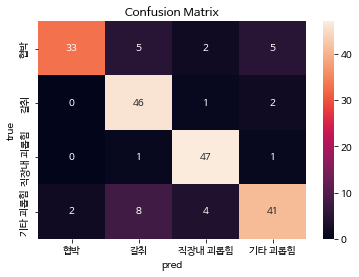

skt/kogpt2-base-v2 파이프라인 종료

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.49.209.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.49.209.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


klue/roberta-base 파이프라인 시작
class
0     896
1     981
2     979
3    1094
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0           0  ...  지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1           1  ...  길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2           2  ...  너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3           3  ...  어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4           4  ...  저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...

[5 rows x 5 columns]
x_train 개수 : 3555
y_train 개수 : 3555
x_val 개수 : 197
y_val 개수 : 197
x_test 개수 : 198
y_test 개수 : 198
훈련 데이터 레이블 비율 확인 : Counter({3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({3: 54, 1: 49, 2: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({3: 55, 1: 49, 2: 49, 0: 45})


Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

223/223 [==============================] - 121s 159ms/step - loss: 0.5506 - accuracy: 0.8042 - val_loss: 0.5929 - val_accuracy: 0.8223


100%|██████████| 198/198 [02:28<00:00,  1.33it/s]


모델이 틀린 데이터 개수 34개
              precision    recall  f1-score   support

           0       0.78      0.96      0.86        45
           1       0.77      1.00      0.87        49
           2       1.00      0.71      0.83        49
           3       0.84      0.67      0.75        55

    accuracy                           0.83       198
   macro avg       0.85      0.84      0.83       198
weighted avg       0.85      0.83      0.82       198



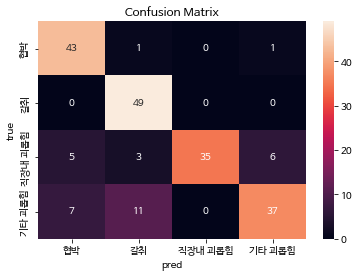

klue/roberta-base 파이프라인 종료

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.49.209.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.49.209.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


monologg/koelectra-base-v3-discriminator 파이프라인 시작
class
0     896
1     981
2     979
3    1094
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0           0  ...  지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1           1  ...  길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2           2  ...  너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3           3  ...  어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4           4  ...  저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...

[5 rows x 5 columns]
x_train 개수 : 3555
y_train 개수 : 3555
x_val 개수 : 197
y_val 개수 : 197
x_test 개수 : 198
y_test 개수 : 198
훈련 데이터 레이블 비율 확인 : Counter({3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({3: 54, 1: 49, 2: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({3: 55, 1: 49, 2: 49, 0: 45})


Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

223/223 [==============================] - 125s 172ms/step - loss: 0.6650 - accuracy: 0.7522 - val_loss: 0.4525 - val_accuracy: 0.8629


100%|██████████| 198/198 [02:26<00:00,  1.35it/s]


모델이 틀린 데이터 개수 21개
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        45
           1       0.93      0.88      0.91        49
           2       0.91      0.88      0.90        49
           3       0.82      0.91      0.86        55

    accuracy                           0.89       198
   macro avg       0.90      0.89      0.90       198
weighted avg       0.90      0.89      0.89       198



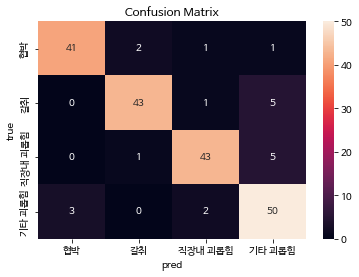

monologg/koelectra-base-v3-discriminator 파이프라인 종료

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.49.209.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.49.209.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


distilbert-base-multilingual-cased 파이프라인 시작
class
0     896
1     981
2     979
3    1094
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0           0  ...  지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1           1  ...  길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2           2  ...  너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3           3  ...  어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4           4  ...  저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...

[5 rows x 5 columns]
x_train 개수 : 3555
y_train 개수 : 3555
x_val 개수 : 197
y_val 개수 : 197
x_test 개수 : 198
y_test 개수 : 198
훈련 데이터 레이블 비율 확인 : Counter({3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({3: 54, 1: 49, 2: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({3: 55, 1: 49, 2: 49, 0: 45})


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

223/223 [==============================] - 77s 120ms/step - loss: 1.0608 - accuracy: 0.5561 - val_loss: 0.8369 - val_accuracy: 0.6853


100%|██████████| 198/198 [01:26<00:00,  2.29it/s]


모델이 틀린 데이터 개수 68개
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        45
           1       0.83      0.69      0.76        49
           2       0.61      0.88      0.72        49
           3       0.61      0.42      0.49        55

    accuracy                           0.66       198
   macro avg       0.67      0.66      0.65       198
weighted avg       0.67      0.66      0.65       198



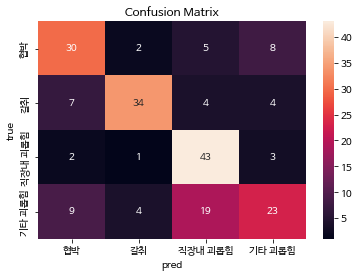

distilbert-base-multilingual-cased 파이프라인 종료



In [81]:
"""
완료
- "klue/bert-base"
- "skt/kogpt2-base-v2"
- "monologg/koelectra-base-v3-discriminator"
- "klue/roberta-base"
- "distilbert-base-multilingual-cased"
"""


# Huggingface에서 사용 가능한 사전학습 모델 리스트입니다.
model_paths = ["klue/bert-base",
               "skt/kogpt2-base-v2",
               "klue/roberta-base",
               "monologg/koelectra-base-v3-discriminator",
               "distilbert-base-multilingual-cased",
               "kykim/bert-kor-base"]      

# 변동 가능한 arguments로 save_path의 예시 : save_path = "./model/sample"
save_path = "./model/no_normal_v1" # 모델이 저장되는 위치
data_path = "./data/no_normal_data_v1.csv" # 학습 데이터 위치
word2vec_path = "../packages/ko.bin" # 사전 학습 임베딩 벡터 저장 위치
batch_size = 16 # 모델에 들어가는 배치 크기
epochs = 2 # 에폭 수


for model_path in model_paths:
  # TPU 작동을 위한 코드
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  with strategy.scope():
    print(f"{model_path} 파이프라인 시작")

    # 데이터 로딩
    load = DataLoad(data_path)
    x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)
    test_text = x_test.copy()
    num_labels = int(max(y_train) + 1)

    # # 데이터 증강
    # data_aug = DataAugmentation(x_train, y_train, word2vec_path)
    # # 데이터 증강 : 유의어 대체
    # sub_rep_x, sub_rep_y = data_aug.sub_rep_dataset(sub_ratio = 0.1)
    # # 데이터 증강 : 같은 레이블 반복
    # repeat_x, repeat_y = data_aug.label_repeat(label_id = 3)
    # # 증강된 데이터들 합치기
    # x_train = x_train + sub_rep_x + repeat_x
    # y_train = y_train + sub_rep_y + repeat_y

    # 데이터셋 구축
    pipeline = TrainPipeline(model_path, num_labels, batch_size, epochs)
    train_dataset = pipeline.dataset(x_train, y_train)
    val_dataset = pipeline.dataset(x_val, y_val)
    if "GPT" in str(pipeline.model):
      test_dataset = pipeline.dataset(x_test, y_test)
      x_test, y_test = test_dataset

    # 모델 학습, 예측, 저장
    model = pipeline.training_dataset(train_dataset, val_dataset)
    score_list, y_pred = pipeline.evaluate_model(x_test)
    pipeline.save_model_tokenizer(save_path)

    # 모델 검증    
    false_list = clf_score(y_test, y_pred)
    false_dataset = false_case_dataset(false_list, test_text, y_test, y_pred)
    eval_dataset = evaluate_result(score_list, test_text, y_pred, y_test)
    save_dataset_path = os.path.join(save_path, "eval_result")
    model_name = model_path.split("/")[-1]
    save_csv(eval_dataset, save_dataset_path, f"{model_name}.csv")
    
    print(f"{model_path} 파이프라인 종료\n")

## Main LSTM 함수

class
0    896
1    896
2    896
3    896
4    896
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0        3277  ...  야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...
1        2347  ...  빨리 돈 구해와 저 정말 돈 나올데가 없어요 제발요 니네 부모님 가게 정리한 돈 어...
2        2756  ...  당신 못배워먹은거 티내지마 냅둬 못배워먹어서 고작 이딴 일이나 하는거지 죄송합니다 ...
3        2461  ...  어제까지 완료 하기로 했던 일은 다 완료 되었나요 어제 급한 일이 있어서 처리를 못...
4        3369  ...  보육원 선생님 맞으시죠 선생님 저 은희예요 저 찾을 생각하지 마세요 안 돌아갈거니까...

[5 rows x 5 columns]
x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


4032it [00:29, 136.16it/s]


훈련 데이터 유의어 대체 증강 완료
증강시킨 데이터 개수 : 4032
----데이터 증강 전 데이터 예시 ----
학생 잠깐 이리로 와봐 왜 그러시죠 요즘 부모들은 어린 애들한테도 명품 옷을 사준다고 하더니 진짜였군 제가 무슨 옷을 입든 무슨 상관이에요 학생들은 학생답게 다녀야지 그 재킷은 오늘부로 내 거다 싫어요 생일선물로 겨우 받은 옷이란 말이에요 일을 복잡하게 만드네 험한 꼴 당하고 싶어 아뇨 그치만 제가 정말 아끼는 옷인데 이번만 봐주시면 안될까요 좋아 그럼 인심 썼다 그 옷 대신 만원 가져와봐 엄마한테 문자할게요 잠시만요
----데이터 증강 후 데이터 예시 ----
학생 잠깐 이리로 와봐 왜 그러시가죠 요즘 부모들은 어린 애들한테도 명품 옷을 사준다고 하더니 가짜였군 제가 무슨 옷을 입든 무슨 상관이에요 학생들은 학생즐겁도록 다녀야지 그 재킷은 오늘부로 내 거다 힘들어요 생일선물로 겨우 받은 옷이란 말이에요 일을 복잡하게 만드네 험한 꼴 당하고 싶어 아뇨 그치만 제가 정말로 아끼는 옷인데 이번만 봐주시면 안될까요 좋아 도대체 인심 썼다 그 옷 대신 만원 가져와봐 엄마한테 문자할게요 잠시만요
훈련 데이터 특정 레이블 반복 증강 완료
반복되는 레이블 id : 3
반복된 횟수 : 1
Epoch 1/10
7/7 [==============================] - 7s 295ms/step - loss: 1.5325 - accuracy: 0.4500 - val_loss: 1.4381 - val_accuracy: 0.2900
Epoch 2/10
7/7 [==============================] - 1s 83ms/step - loss: 1.1930 - accuracy: 0.4500 - val_loss: 1.3037 - val_accuracy: 0.3600
Epoch 3/10
7/7 [==============================] - 1s 83ms/step - loss: 1.1438 - accuracy: 0.4600 - val_l

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


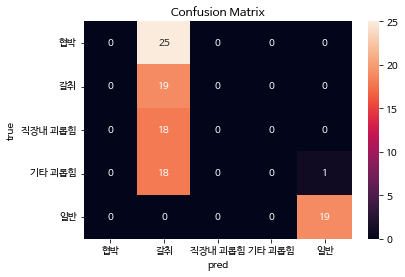

In [ ]:
spm_path = "./bpe_10000_train_spm.model"
word2vec_path = "../packages/ko.bin"
batch_size = 16
vocab_size = 10000


# 데이터 로딩
load = DataLoad(data_path)
x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)
num_labels = int(max(y_train) + 1)
test_text = x_test.copy()

# 데이터 증강
data_aug = DataAugmentation(x_train, y_train, word2vec_path)
# 데이터 증강 : 유의어 대체
sub_rep_x, sub_rep_y = data_aug.sub_rep_dataset(sub_ratio = 0.1)
# 데이터 증강 : 같은 레이블 반복
repeat_x, repeat_y = data_aug.label_repeat(label_id = 3)
# 증강된 데이터들 합치기
x_train = x_train + sub_rep_x + sub_rep_x
y_train = y_train + sub_rep_y + sub_rep_y

# 데이터셋 구축 : 토큰화
lstmpipline = LSTMpipeline(spm_path, vocab_size, epochs = 1)
x_train, y_train = lstmpipline.tokenization(x_train, y_train)
x_val, y_val = lstmpipline.tokenization(x_val, y_val)
x_test, y_test = lstmpipline.tokenization(x_test, y_test)
# 데이터셋 구축 : 패딩
max_length = max([max(map(lambda x : len(x), tmp)) for tmp in [x_train, x_val, x_test]])
x_train = lstmpipline.padding(x_train, max_length)
x_val = lstmpipline.padding(x_val, max_length)
x_test = lstmpipline.padding(x_test, max_length)
# 데이터셋 구축 : 넘파이 데이터셋
train_dataset = lstmpipline.dataset(x_train, y_train, lstm = True)
val_dataset = lstmpipline.dataset(x_val, y_val, lstm = True)

# LSTM 모델 학습
model = lstmpipline.training_dataset(train_dataset, val_dataset, max_length)
score_list, y_pred = lstmpipline.evaluate_model(x_test)
lstmpipline.save_model_tokenizer(save_path + "/LSTM")

# 모델 검증
false_list = clf_score(y_test, y_pred)
false_dataset = false_case_dataset(false_list, test_text, y_test, y_pred)
eval_dataset = evaluate_result(score_list, test_text, y_pred, y_test.reshape(-1))
save_dataset_path = os.path.join(save_path, "eval_result")
save_csv(eval_dataset, save_dataset_path, "LSTM.csv")

## 앙상블 Soft voting

In [82]:
import pandas as pd
from collections import defaultdict
from glob import glob

def load_result_df(save_path_2):
  csv_dic = defaultdict()
  path_list = glob(save_path_2 + "/eval_result/*")
  key_list = []
  for path in path_list:
    key = path.split("/")[-1]
    key_list.append(key)
    csv_dic[key] = pd.read_csv(path)
  csv_dic = dict(csv_dic)
  print(f"모델명 : {key_list}")
  print(f"변수명 : {list(csv_dic[key_list[0]].columns)}")
  return csv_dic, key_list


save_path = ["./model/no_normal_v1"]
csv_dic = dict()            

for path in save_path:
  dic, key_list = load_result_df(path)
  csv_dic.update(dic)
  key_list += key_list

모델명 : ['bert-base.csv', 'kogpt2-base-v2.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'distilbert-base-multilingual-cased.csv']
변수명 : ['Unnamed: 0', 'x_test', 'y_pred', 'y_test', 'label_0', 'label_1', 'label_2', 'label_3']


In [90]:
from itertools import combinations

total_case = []
for i in range(1, len(key_list)+1):
  total_case = total_case + list(combinations(key_list[:-1], i))
total_case = list(map(list, total_case))
print(f"앙상블 경우의 수 : {len(total_case)}가지")

앙상블 경우의 수 : 511가지


#### Stacking(미완성)

In [ ]:
one_case = total_case[:4]
one_case = sum(one_case, [])
label_score_list = []
for key in one_case:
  label_score_list.append(csv_dic[key].iloc[:,-5:].to_numpy())
label_score_list = np.array(label_score_list)

In [ ]:
stack_input = label_score_list.reshape(-1, len(one_case), 5)
print(stack_input.shape)
stack_output = csv_dic["LSTM.csv"]["y_test"].to_numpy().reshape(-1,1)
print(stack_output.shape)

(224, 4, 5)
(224, 1)


In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(stack_input, stack_output, test_size=0.1)

In [ ]:
inputs0 = tf.keras.layers.Input(shape = (x_tr.shape[-1]))
inputs1 = tf.keras.layers.Input(shape = (x_tr.shape[-1]))
inputs2 = tf.keras.layers.Input(shape = (x_tr.shape[-1]))
inputs3 = tf.keras.layers.Input(shape = (x_tr.shape[-1]))

layers0 = tf.keras.layers.Dense(1)(inputs0)
layers1 = tf.keras.layers.Dense(1)(inputs1)
layers2 = tf.keras.layers.Dense(1)(inputs2)
layers3 = tf.keras.layers.Dense(1)(inputs3)

concat = tf.keras.layers.concatenate([layers0, layers1, layers2, layers3])
outputs = tf.keras.layers.Dense(5, activation = "softmax")(concat)

stack_model = tf.keras.Model([inputs0, inputs1, inputs2, inputs3], outputs)
stack_model.compile(optimizer = "adam",
                    loss = "sparse_categorical_crossentropy",
                    metrics = ["accuracy"])
stack_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_74 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_75 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_76 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_77 (InputLayer)          [(None, 5)]          0           []                               
                                                                                           

In [ ]:
tmp = [x_tr[:,i,:] for i in range(len(one_case))]
te_tmp = [x_te[:,i,:] for i in range(len(one_case))]
print(len(tmp), tmp[0].shape)
print(y_tr.shape)
stack_model.fit(tmp, y_tr, epochs = 1000, verbose=1,
                validation_data = (te_tmp, y_te),
                batch_size = 16)

4 (201, 5)
(201, 1)
Epoch 1/1000
13/13 [==============================] - 1s 14ms/step - loss: 1.6253 - accuracy: 0.2338 - val_loss: 1.6097 - val_accuracy: 0.1739
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.6133 - accuracy: 0.2488 - val_loss: 1.6165 - val_accuracy: 0.1739
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.6047 - accuracy: 0.2537 - val_loss: 1.6266 - val_accuracy: 0.1739
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5988 - accuracy: 0.2488 - val_loss: 1.6345 - val_accuracy: 0.1304
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5916 - accuracy: 0.2587 - val_loss: 1.6419 - val_accuracy: 0.1304
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5875 - accuracy: 0.2637 - val_loss: 1.6489 - val_accuracy: 0.1304
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5826 - accuracy: 0.2836 - val_loss: 1.6562 - val_ac

#### Soft voting

25번째 모델 경우의 수 : ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.91      0.98      0.94        49
           2       0.93      0.88      0.91        49
           3       0.94      0.87      0.91        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



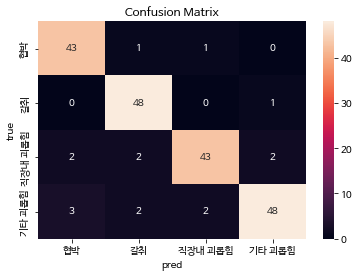

30번째 모델 경우의 수 : ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.91      0.98      0.94        49
           2       0.93      0.88      0.91        49
           3       0.94      0.87      0.91        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



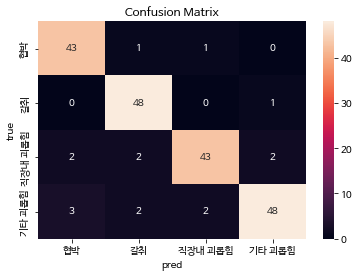

34번째 모델 경우의 수 : ['koelectra-base-v3-discriminator.csv', 'roberta-base.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.91      0.98      0.94        49
           2       0.93      0.88      0.91        49
           3       0.94      0.87      0.91        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



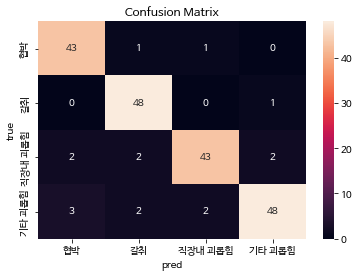

45번째 모델 경우의 수 : ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.91      0.98      0.94        49
           2       0.93      0.88      0.91        49
           3       0.94      0.87      0.91        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



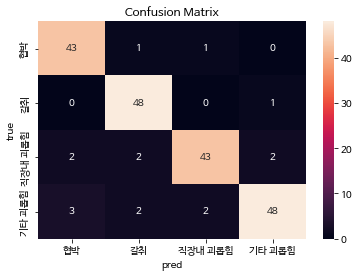

53번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



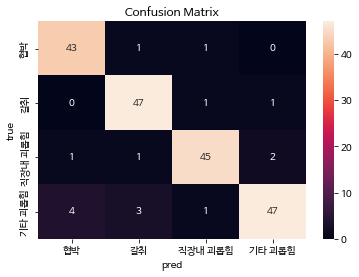

58번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



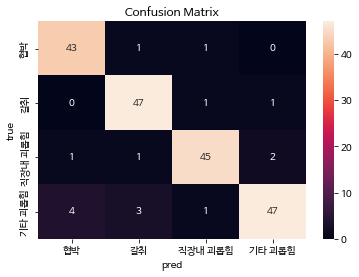

62번째 모델 경우의 수 : ['bert-base.csv', 'koelectra-base-v3-discriminator.csv', 'roberta-base.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



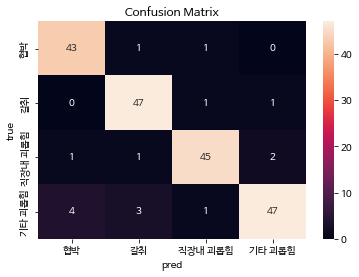

73번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



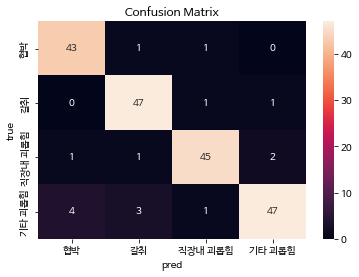

96번째 모델 경우의 수 : ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'bert-base.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



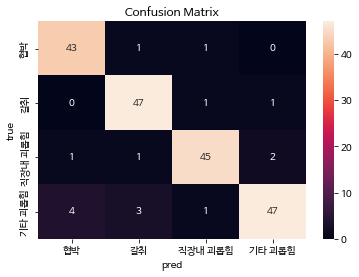

106번째 모델 경우의 수 : ['roberta-base.csv', 'bert-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



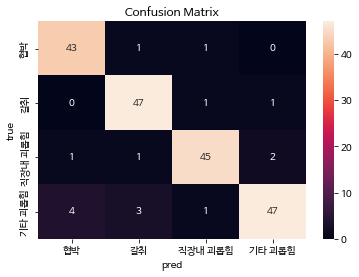

115번째 모델 경우의 수 : ['koelectra-base-v3-discriminator.csv', 'bert-base.csv', 'roberta-base.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



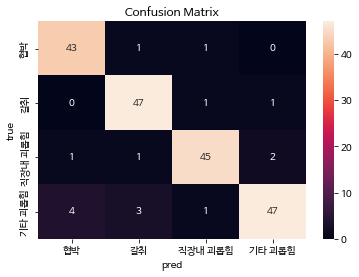

128번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



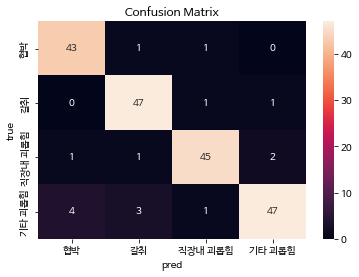

140번째 모델 경우의 수 : ['bert-base.csv', 'kogpt2-base-v2.csv', 'koelectra-base-v3-discriminator.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        45
           1       0.94      0.94      0.94        49
           2       0.94      0.94      0.94        49
           3       0.87      0.87      0.87        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



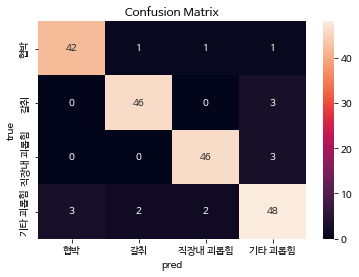

174번째 모델 경우의 수 : ['bert-base.csv', 'koelectra-base-v3-discriminator.csv', 'kogpt2-base-v2.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        45
           1       0.94      0.94      0.94        49
           2       0.94      0.94      0.94        49
           3       0.87      0.87      0.87        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



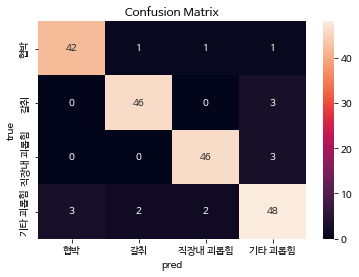

207번째 모델 경우의 수 : ['kogpt2-base-v2.csv', 'koelectra-base-v3-discriminator.csv', 'bert-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        45
           1       0.94      0.94      0.94        49
           2       0.94      0.94      0.94        49
           3       0.87      0.87      0.87        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



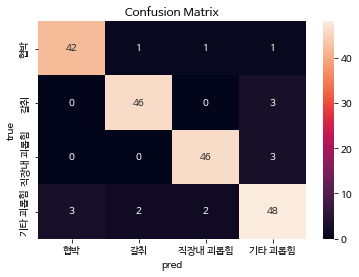

230번째 모델 경우의 수 : ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.91      0.98      0.94        49
           2       0.93      0.88      0.91        49
           3       0.94      0.87      0.91        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



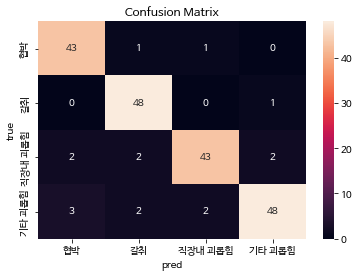

248번째 모델 경우의 수 : ['koelectra-base-v3-discriminator.csv', 'bert-base.csv', 'kogpt2-base-v2.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        45
           1       0.94      0.94      0.94        49
           2       0.94      0.94      0.94        49
           3       0.87      0.87      0.87        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



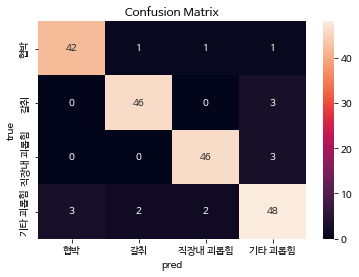

297번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'bert-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        45
           1       0.94      0.96      0.95        49
           2       0.92      0.94      0.93        49
           3       0.92      0.85      0.89        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



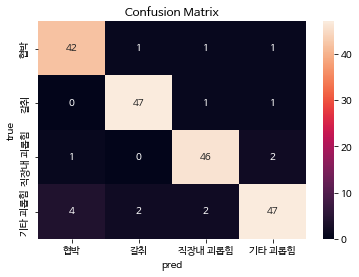

300번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.88      0.96      0.91        45
           1       0.91      0.98      0.94        49
           2       0.96      0.90      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



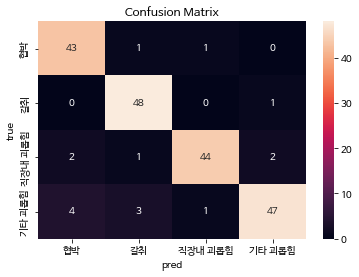

319번째 모델 경우의 수 : ['bert-base.csv', 'koelectra-base-v3-discriminator.csv', 'bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        45
           1       0.94      0.96      0.95        49
           2       0.92      0.94      0.93        49
           3       0.92      0.85      0.89        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



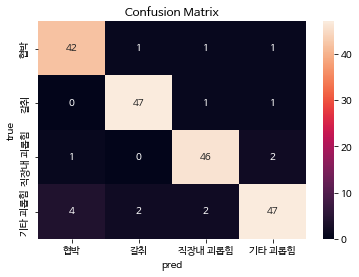

369번째 모델 경우의 수 : ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.88      0.96      0.91        45
           1       0.91      0.98      0.94        49
           2       0.96      0.90      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



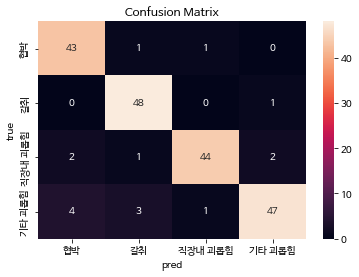

425번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.96      0.92        45
           1       0.90      0.96      0.93        49
           2       0.94      0.92      0.93        49
           3       0.94      0.85      0.90        55

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



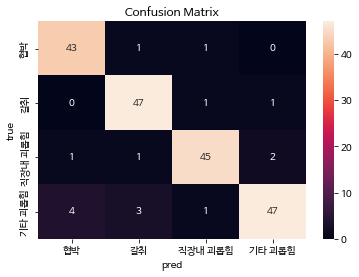

In [94]:
for idx, case in enumerate(total_case):
  # 레이블 별 평균 점수 산출
  label_score_list = []
  for key in case:
    label_score_list.append(csv_dic[key].iloc[:,-4:].to_numpy())
  label_score_list = np.array(label_score_list)


  score_average = np.average(label_score_list, axis = 0)
  soft_voting = np.argmax(score_average, axis = -1)

  # 정답값과 예측값을 구하며 서로 맞지 않는 경우의 수도 구함
  y_pred = soft_voting.tolist()
  y_test = csv_dic[key_list[0]]["y_test"].tolist()
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  if len(false_list) <= 16:
    print(f"{idx+1}번째 모델 경우의 수 : {case}")
    clf_score(y_test, y_pred)

    # 잘못 예측한 케이스가 담긴 데이터셋
    x_test = csv_dic[key_list[0]]["x_test"]
    false_score_dataset = pd.DataFrame(score_average)
    false_score_dataset.add_prefix("label_")
    
    false_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_true":y_test})
    total_dataset = pd.concat([false_dataset, false_score_dataset], axis = 1)

    total_dataset = total_dataset.iloc[false_list, :]

![image](https://user-images.githubusercontent.com/51338268/153782534-b112fe81-c73b-48ee-9084-9ad08135b572.png)
![image](https://user-images.githubusercontent.com/51338268/153782561-d0b9abc2-ed88-432d-ba7d-8c23a3ba1258.png)

유의어 대체를 하는 데이터 증강을 같은 데이터를 2번한 훈련 데이터에 klue-bert-base, klue-roberta-base, bert-base 모델을 앙상블 하였을 때의 결과가 가장 좋은 F1-score를 만드는 것을 발견하였습니다.

In [ ]:
for i in range(len(false_dataset)):
  sentence, prediction, real =false_dataset.iloc[i, :]
  print(f"예측 분류 : {prediction}")
  print(f"실제 분류 : {real}")
  print(sentence)
  print("\n")

In [ ]:
false_dataset.to_excel("./오분류예제.xlsx")

## Translate - Interpret - XAI

In [74]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/prototype_model')

data_path = "./data/sample_data_v3.csv" # 학습 데이터 위치
load = DataLoad(data_path)
x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
class
0     896
1     981
2     979
3    1094
4    4536
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0           0  ...  지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1           1  ...  길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2           2  ...  너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3           3  ...  어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4           4  ...  저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...

[5 rows x 5 columns]
x_train 개수 : 7637
y_train 개수 : 7637
x_val 개수 : 424
y_val 개수 : 424
x_test 개수 : 425
y_test 개수 : 425
훈련 데이터 레이블 비율 확인 : Counter({4: 4082, 3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({4: 227, 3: 54, 1: 49, 2: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({4: 227, 3: 55, 2: 49, 1: 49, 0: 45})


In [100]:
from collections import defaultdict
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

model_dict = defaultdict()

#모델 불러오기 
paths = ['./model/no_normal_v1/klue-roberta-base', 
         './model/no_normal_v1/koelectra-base-v3-discriminator']

for path in paths:
  model =  AutoModelForSequenceClassification.from_pretrained(path, from_tf=True) 
  tokenizer = AutoTokenizer.from_pretrained(path)

  #다중분류 설명자 생성
  multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
  model_dict[path] = [multiclass_explainer(text) for text in tqdm(x_test)]
model_dict = dict(model_dict)  

All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.
100%|██████████| 198/198 [13:50<00:00,  4.20s/it]
404 Client Error: Not Found for url: https://huggingface.co/./model/no_normal_v1/koelectra-base-v3-discriminator.csv/resolve/main/config.json


OSError: ignored

In [ ]:
i = 2
sample = x_test[i]
sample_label = y_test[i]
print(f"실제 레이블 : {sample_label}")

word_attributions = multiclass_explainer(sample)
html = multiclass_explainer.visualize()

실제 레이블 : 3


![image](https://user-images.githubusercontent.com/51338268/153794280-135e46fb-3bb8-4af1-9bb6-a40e91645bfd.png)

IndexError : index out of range is self 에러는 임베딩 층에서 vocab_size가 안맞아서 생기는 에러로 생각되며 모델 학습 파이프라인에서 `self.model.resize_token_embeddings(len(self.tokenizer))`을 추가해서 해결하였습니다.

In [76]:
for idx, i in enumerate(range(350,360)):
  sample = test_set["text"][i]
  print(idx, sample)
  print(test_set["new_class"][i], test_set["class"][i])
  word_attributions = multiclass_explainer(sample)
  html = multiclass_explainer.visualize()
  print("\n")

0 씨파 이것들이 지금 내가 우스워 아닙니다 형님 죄송합니다 피맛을 니들이 아직 못봤지 잘못했습니다 살려주십시요 흑흑흑 야 눈알 하나씩 뽑자 눈 하나없어도 다 보이제 형님 살려만 주십시요 시키는건 다하겠습니다 내손에 피 묻히기전에 해라 응
0 [[{'label': 'LABEL_0', 'score': 0.9645214676856995}, {'label': 'LABEL_1', 'score': 0.015770332887768745}, {'label': 'LABEL_2', 'score': 0.007505516055971384}, {'label': 'LABEL_3', 'score': 0.012202720157802105}]]




1 다시 못걸어다니게 만들어줄까 어 이러지마세요 난 분명히 시간을 줬다 제가 할 수 없는 일이에요 그래 그러면 어쩔 수 없네 이제 못걷는거지 뭐 왜이러세요 빨리빨리 시키는 대로 했어야지 어떻게 시간을 좀 더 주세요 다음번에도 안되어 있으면 못걷는거에서 안끝날 줄 알아 알겠어 네 어떻게든 해보겠습니다
0 [[{'label': 'LABEL_0', 'score': 0.8909017443656921}, {'label': 'LABEL_1', 'score': 0.03653247281908989}, {'label': 'LABEL_2', 'score': 0.02644791267812252}, {'label': 'LABEL_3', 'score': 0.046117838472127914}]]




2 누 누구세요 너 서울대학교 붙었지 아 네 그걸 어떻게 제발 살려주세요 왜그러세요 너 어디학과지 입학취소해 지금 아 제발 제발 그것만은 안돼요 저희 집 빚만 4억이에요 어머니는 이미 입원하셨구요 제가 반드시 서울대가서 성공해야해요 서울대 가기전에 그냥 죽고 못갈래 정말 제발 부탁이에요 제발 빨리 취소해 내 딸이 예비1번이야 니가 나가야 들어갈거 아니야 아 알겠어요 제발 칼 좀 치워주세요
0 [[{'label': 'LABEL_0', 'score': 0.5389413237571716}, {'label': 'LABEL_1', 'score': 0.43937456607818604}, {'label': 'LABEL_2', 'score': 0.003259800374507904}, {'label': 'LABEL_3', 'score': 0.018424320966005325}]]




3 야 돈내놔 없어 10원당 한대 맞고싶냐 진짜 없단말이야 가져오라면 가져와 흑흑 나한테 왜그러는거야 뭐긴 너가 만만하니까 그만 괴롭히면 안돼 이미 많이 뜯어갔잖아 나이제 진짜 돈없어 여물고 내일도 잘부탁한다
1 [[{'label': 'LABEL_0', 'score': 0.010501924902200699}, {'label': 'LABEL_1', 'score': 0.8967614769935608}, {'label': 'LABEL_2', 'score': 0.0036685464438050985}, {'label': 'LABEL_3', 'score': 0.08906800299882889}]]




4 야 박사원 너 이번 주말에 내 차 세차 좀 해라 부장님 이번 주말에 제가 약속이 있어서 아니 너가 저번에 해준다며 맡겨만 달라며 그렇다고 하루 전에 그러시면 어떡합니까 뭐야 이거 대드는거야 됐고 이번 주말에 무조건 해놔 아니 부장님 이거 안해놓으면 이번 평가에서 불이익있을거야 네 알겠습니다
2 [[{'label': 'LABEL_0', 'score': 0.007519857957959175}, {'label': 'LABEL_1', 'score': 0.005386273376643658}, {'label': 'LABEL_2', 'score': 0.9824163913726807}, {'label': 'LABEL_3', 'score': 0.0046774959191679955}]]




5 야 김대리 니 주말에 뭐했냐 아 그냥 쉬었습니다 아 그냥 쉬어 말 좀 짧다이 어 집에서 그냥 친구랑 배달 시켜먹고 쉬어서 그랬습니다 왜그러세요 과장님 그냥 쉬었다는데 아니 내가 물어보지도 못해 뭐 내가 여친이랑 있었는지 물어본것도 아니고 안그래 김대리 여친이랑 있었어 아 아뇨 그냥 친구입니다 어 반응 뭐야 여친이랑 있었나본데 아닙니다 그냥 대학 동기였습니다 그게 아닌 것 같은데 이새끼 뭐했냐 여친이랑
2 [[{'label': 'LABEL_0', 'score': 0.004484943114221096}, {'label': 'LABEL_1', 'score': 0.003317762864753604}, {'label': 'LABEL_2', 'score': 0.985880970954895}, {'label': 'LABEL_3', 'score': 0.00631633261218667}]]




6 과장님 저 이번주 금요일에 하루 휴가 좀 써도 될까요 휴가 반차 월차 아 월차로 쓰려고 합니다 월차인지 반차인지 부터 먼저 똑바로 확실하게 말해야될거아냐 답답하게 아 하루 라고만 말씀드렸는데 확실히 말씀 못드려서 죄송합니다 아 하루라고 말했는데 내가 못 알아들은게 병신이다 아 아니요 그런 의미 아닙니다 죄송합니다 됐어 말도 제대로 못하는게 무슨 휴가야 나중에 다시 보고해 네 나중에 다시 보고하라는 말씀이십니까 그래 나중에 나 기분 좋아보일 때 다시와
2 [[{'label': 'LABEL_0', 'score': 0.006609627045691013}, {'label': 'LABEL_1', 'score': 0.003486187430098653}, {'label': 'LABEL_2', 'score': 0.9854361414909363}, {'label': 'LABEL_3', 'score': 0.004468061961233616}]]




7 미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요 네 합니다 보고서를 보니 저에게 상의 안한 내용이 올라갔던데요 대표님과 바로 상의하여 결제 올렸습니다 미나씨 지금 미나씨 직속 상사가 누군지 몰라 죄송합니다 미나씨가 낙하산인건 알겠지만 기본적인건 지켜야 할 거 아니예요 네 미나씨 결제 다시 올리세요 네 알겠습니다
2 [[{'label': 'LABEL_0', 'score': 0.006640712730586529}, {'label': 'LABEL_1', 'score': 0.006890776101499796}, {'label': 'LABEL_2', 'score': 0.9812938570976257}, {'label': 'LABEL_3', 'score': 0.005174675956368446}]]




8 너 이 옷 어디서 났어 엄마가 사주셨어 예쁘지 어 나 빌려주라 뭐 안돼 친구끼리 옷도 못 빌려줘 이건 엄마가 사준 새옷이란 말야 됐고 일주일만 빌려줘 좋은말로할때 너 저번에도 내 옷 빌려간다해놓고 아직 안줬잖아 죽고싶어 어디서 말대꾸야 빨리 내놔 안돼
1 [[{'label': 'LABEL_0', 'score': 0.016757333651185036}, {'label': 'LABEL_1', 'score': 0.9572809338569641}, {'label': 'LABEL_2', 'score': 0.0020666848868131638}, {'label': 'LABEL_3', 'score': 0.023895060643553734}]]




9 어이 너 어디살아 네 예쁘게 생곘네 이러지 마세요 좋지 맞지 좋다고 안하면 한대 확 때려버린다 그만하세요 나얘기 아직 안끝났어 그냥가면 저세상 갈수도 있어 왜그러세요 빨리 끝내줄게 악
0 [[{'label': 'LABEL_0', 'score': 0.9434624910354614}, {'label': 'LABEL_1', 'score': 0.020964965224266052}, {'label': 'LABEL_2', 'score': 0.003413249272853136}, {'label': 'LABEL_3', 'score': 0.03215924650430679}]]


## Submission 제출

In [21]:
import json


test_path = "/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/data/TUNiB/test.json"
with open(test_path, "r", encoding = "utf-8") as st_json:
    test = json.load(st_json)

In [22]:
def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣0-9]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

test_set = pd.DataFrame()
test_set["text"] = pd.read_json(test_path).T["text"].apply(lambda x : remove_punctuation(x))

In [ ]:
k = 0
tmp = []
for i, j in zip(list(test_set.index), test_set["text"]):
  print(i, k, j)
  if int(i[2:]) != k:
    tmp += [(i,j)]
  k += 1

t_000 0 야 임마 돈을 빨리 갚아야 될것 아니야 죄송합니다 갑자기 돈이 필요하신 줄은 몰랐습니다 항상 준비를 해놔야 하는게 정상 아니냐 이 비정상아 아니 애초에 돈을 빌릴때 여유시간이 많이 있는걸로 알고 있었는데요 너 지금 나한테 대드냐 아 죄송합니다 아니 애초에 돈을 많이 안 가진 상태면 빌리지를 말아 새끼야 네 알겠습니다 아참 지금 돈 갚을 때 이자 이십오 퍼센트는 기본으로 하고 나한테 대든 죄야
t_001 1 너 지금 만나는 여자 내 여자친구 아니야 미안 어쩌다 보니 그렇게 됐다 좋은 걸 어떡하냐 넌 말이 참 쉽네 우리가 몇 년 친군데 네가 어떻게 나한테 그럴 수 있어 야 우리 수진이도 내가 좋다는데 이제 와서 뭘 어떡하려고 네가 그냥 넘어가주라 우리 수진이라니 걔가 왜 네 수진인데 여자가 세상에 걔 하나냐 친구 좋다는 게 다 뭐야 한 번만 봐주라 친구 우리가 친구면 니가 이 따위로 나오면 안 됐지 아 미안하다니까 진짜 질리게 뭐라 그러네 뭐 내가 학교에 다 소문 내고 너랑 정수진 죽여 버릴 거야 얘가 미쳤나 진정하고 얘기해
t_002 2 오늘 저녁에 뭐하나 지수씨 퇴근하면 집에서 쉬려구요 잘됐네 나랑 밥이나 한끼하고 영화나 볼까 네 제가 과장님이랑요 왜 업무의 연장이라고 생각해 그게 싫으면 데이트라고 생각하든지 데이트요 과장님 결혼하셨잖아요 우리애들이랑 와이프 외국 나가있잖아 지수씨몰랐어 네 그래서 집에 들어가기가 너무 외로워 쓸쓸해 직장상사의 고충도 함께 나눠가져야 진정한 동료라고 할수 있지 않겠어 그래도 단둘이는 차라리 다른 분들도 같이 저녁에 만나는건 어떨까요 지수씨 내가 불편해 내가 변태야 아니 그게 아니라 그게 아니면 왜이렇게 오바야 밥한끼 먹자는거 가지고 죄송합니다
t_003 3 야 체육복 좀 빌려주라 나 다음시간 체육인데 나 지금 체육시간이니까 좀 빌려달라고 그치만 다른 반 얘한테 빌리면 안될까 아 체육복 안입으면 혼나는 거 모르냐고 그래서 나도 바로 입고 가야해서 니가 쳐 혼나는 건 내 알빠아닌데 짜증나게 하지말고 내놔라 바로 가져다

In [ ]:
test_set.head()

,text
t_000,야 임마 돈을 빨리 갚아야 될것 아니야 죄송합니다 갑자기 돈이 필요하신 줄은 몰랐습...
t_001,너 지금 만나는 여자 내 여자친구 아니야 미안 어쩌다 보니 그렇게 됐다 좋은 걸 어...
t_002,오늘 저녁에 뭐하나 지수씨 퇴근하면 집에서 쉬려구요 잘됐네 나랑 밥이나 한끼하고 영...
t_003,야 체육복 좀 빌려주라 나 다음시간 체육인데 나 지금 체육시간이니까 좀 빌려달라고 ...
t_004,제가 뭘 그렇게 잘못했죠 일이던 뭐던 잘하는 게 뭐가 있다고 그래 뭘 그렇게 잘못했...


In [23]:
from glob import glob

model_paths = [i for i in glob("./model/tmp_v1/klue-roberta-base") if "eval_result" not in i]
bucket_pred = []
for model_path in model_paths:
  loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
  loaded_model = TFAutoModelForSequenceClassification.from_pretrained(model_path)

  text_classifier = TextClassificationPipeline(
      tokenizer=loaded_tokenizer, 
      model=loaded_model, 
      framework='tf',
      return_all_scores=True
  )
  tqdm.pandas()
  test_set["class"] = test_set["text"].progress_apply(lambda x : text_classifier(x))
  bucket_pred.append(test_set)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./model/tmp_v1/klue-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
100%|██████████| 400/400 [03:17<00:00,  2.03it/s]


In [25]:
test_set["new_class"] = test_set["class"].apply(lambda x : x[0])
test_set["new_class"] = test_set["new_class"].apply(lambda y : list(map(lambda x : x["score"], y)))
test_set["new_class"] = test_set["new_class"].apply(lambda x : np.argmax(x))

In [34]:
import json

test_path = "/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/data/TUNiB/test.json"
with open(test_path, "r", encoding = "utf-8") as st_json:
    test = json.load(st_json)

def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣0-9]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

test_set = pd.DataFrame()
test_set["text"] = pd.read_json(test_path).T["text"].apply(lambda x : remove_punctuation(x))    

In [48]:
from glob import glob
from copy import deepcopy

model_paths = ["./model/tmp_v1/klue-bert-base",
               "./model/no_normal_v1/klue-bert-base"]
bucket_pred = []
for model_path in model_paths:
  loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
  loaded_model = TFAutoModelForSequenceClassification.from_pretrained(model_path)

  text_classifier = TextClassificationPipeline(
      tokenizer=loaded_tokenizer, 
      model=loaded_model, 
      framework='tf',
      return_all_scores=True
  )
  tqdm.pandas()
  tmp = deepcopy(test_set["text"].progress_apply(lambda x : text_classifier(x)))
  tmp = tmp.apply(lambda x : x[0])
  tmp = tmp.apply(lambda y : list(map(lambda x : x["score"], y)))
  tmp = tmp.apply(lambda x : np.argmax(x))
  bucket_pred.append(tmp)

Some layers from the model checkpoint at ./model/tmp_v1/klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_227']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/tmp_v1/klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
100%|██████████| 400/400 [03:13<00:00,  2.07it/s]


In [71]:
tmp_v1, no_normal = bucket_pred

In [72]:
tmp_v1

t_000    [[{'label': 'LABEL_0', 'score': 0.260894566774...
t_001    [[{'label': 'LABEL_0', 'score': 0.281802386045...
t_002    [[{'label': 'LABEL_0', 'score': 0.234600961208...
t_003    [[{'label': 'LABEL_0', 'score': 0.295504301786...
t_004    [[{'label': 'LABEL_0', 'score': 0.292067021131...
                               ...                        
t_493    [[{'label': 'LABEL_0', 'score': 0.246189758181...
t_494    [[{'label': 'LABEL_0', 'score': 0.247233912348...
t_495    [[{'label': 'LABEL_0', 'score': 0.244296550750...
t_498    [[{'label': 'LABEL_0', 'score': 0.301159858703...
t_499    [[{'label': 'LABEL_0', 'score': 0.264443367719...
Name: text, Length: 400, dtype: object

In [73]:
no_normal

t_000    [[{'label': 'LABEL_0', 'score': 0.099703177809...
t_001    [[{'label': 'LABEL_0', 'score': 0.918894469738...
t_002    [[{'label': 'LABEL_0', 'score': 0.004912229254...
t_003    [[{'label': 'LABEL_0', 'score': 0.011425375938...
t_004    [[{'label': 'LABEL_0', 'score': 0.987257897853...
                               ...                        
t_493    [[{'label': 'LABEL_0', 'score': 0.054907150566...
t_494    [[{'label': 'LABEL_0', 'score': 0.006105354055...
t_495    [[{'label': 'LABEL_0', 'score': 0.014122288674...
t_498    [[{'label': 'LABEL_0', 'score': 0.053013470023...
t_499    [[{'label': 'LABEL_0', 'score': 0.258296489715...
Name: text, Length: 400, dtype: object

In [64]:
np.array(tmp_v1) == np.array(no_normal)

array([False,  True, False, False,  True, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False,  True,
       False, False,  True,  True,  True,  True,  True, False, False,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False,  True, False,  True, False, False, False,
        True, False,  True, False,  True, False,  True,  True,  True,
        True, False,  True, False,  True,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False, False,
       False,  True, False,  True, False, False,  True, False,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True, False, False, False,
       False,  True, False, False, False,  True, False, False,  True,
        True, False, False,  True,  True, False,  True, False, False,
       False,  True,

In [65]:
sum(np.array(tmp_v1) == np.array(no_normal))

185

In [67]:
no_normal.index

Index(['t_000', 't_001', 't_002', 't_003', 't_004', 't_005', 't_006', 't_008',
       't_010', 't_013',
       ...
       't_488', 't_489', 't_490', 't_491', 't_492', 't_493', 't_494', 't_495',
       't_498', 't_499'],
      dtype='object', length=400)

In [68]:
indexes = no_normal.index

answer = defaultdict()
tmp = defaultdict()
for idx, case in enumerate(indexes):
  tmp = str(0) + str(no_normal[idx])
  answer[case] = dict({"class":tmp})
answer = dict(answer)

In [69]:
answer

{'t_000': {'class': '01'},
 't_001': {'class': '00'},
 't_002': {'class': '02'},
 't_003': {'class': '01'},
 't_004': {'class': '00'},
 't_005': {'class': '00'},
 't_006': {'class': '02'},
 't_008': {'class': '03'},
 't_010': {'class': '01'},
 't_013': {'class': '03'},
 't_014': {'class': '03'},
 't_015': {'class': '00'},
 't_016': {'class': '02'},
 't_018': {'class': '02'},
 't_019': {'class': '00'},
 't_021': {'class': '01'},
 't_022': {'class': '00'},
 't_023': {'class': '00'},
 't_024': {'class': '02'},
 't_025': {'class': '02'},
 't_026': {'class': '00'},
 't_027': {'class': '03'},
 't_028': {'class': '03'},
 't_029': {'class': '01'},
 't_030': {'class': '00'},
 't_031': {'class': '01'},
 't_032': {'class': '00'},
 't_034': {'class': '00'},
 't_035': {'class': '01'},
 't_036': {'class': '02'},
 't_037': {'class': '01'},
 't_038': {'class': '03'},
 't_040': {'class': '03'},
 't_041': {'class': '01'},
 't_042': {'class': '01'},
 't_043': {'class': '00'},
 't_044': {'class': '02'},
 

In [70]:
with open('./submission/no_normal_bert_answer.json', 'w') as fp:
    json.dump(answer, fp)

In [ ]:
test_set["new_class"][0].sort(key = lambda x : x["score"], reverse = True)

In [ ]:
test_set["new_class"][0]

[{'label': 'LABEL_4', 'score': 0.0015467636985704303},
 {'label': 'LABEL_2', 'score': 0.018175235018134117},
 {'label': 'LABEL_0', 'score': 0.020114317536354065},
 {'label': 'LABEL_3', 'score': 0.10499970614910126},
 {'label': 'LABEL_1', 'score': 0.8551638722419739}]

In [ ]:
# 12, 30, 37, 53, 55, 65, 100, 101, 132, 138, 156, 194
a, b = test_set.iloc[37,:]
a,b

('야 프론트엔드 개발자들 자네들 미쳤냐 어 죄송하지만 야 백엔드 작업자들은 작업량이 이 정도나 많이 있는데 니들은 뭐야 어린애 오줌만큼 하고 죄송합니다 하지만 저희도 정석대로 열심히 했는데 시끄러 임마 열심히 하면 뭐해 원래 하라고 한 만큼 한거잖아요 왜 그러시는지 이해가 안돼요 야 작업량 차이가 많이 나니까 이런소리가 나오지 밥버러지 놈들 너무 뭐라고 안해주셨으면 좋겠어요 얘들 때문에 편한것도 있어요 아이고 알겠다 이쁜것들 프론트 엔드 실력없으면 나가던지 실력을 키우던지 해 죄송합니다 너무 낙심하지말고 일을 즐기고 배우는 것도 즐겨 야 위로 해주지마 버러지들 같으니라고',
 [[{'label': 'LABEL_0', 'score': 0.0016043970827013254},
   {'label': 'LABEL_1', 'score': 0.0005760781932622194},
   {'label': 'LABEL_2', 'score': 0.9872031807899475},
   {'label': 'LABEL_3', 'score': 0.010171759873628616},
   {'label': 'LABEL_4', 'score': 0.0004446330131031573}]])

In [ ]:
test_set["class"] = test_set

,text,class
t_000,야 임마 돈을 빨리 갚아야 될것 아니야 죄송합니다 갑자기 돈이 필요하신 줄은 몰랐습...,"[[{'label': 'LABEL_0', 'score': 0.439652711153..."
t_001,너 지금 만나는 여자 내 여자친구 아니야 미안 어쩌다 보니 그렇게 됐다 좋은 걸 어...,"[[{'label': 'LABEL_0', 'score': 0.983539104461..."
t_002,오늘 저녁에 뭐하나 지수씨 퇴근하면 집에서 쉬려구요 잘됐네 나랑 밥이나 한끼하고 영...,"[[{'label': 'LABEL_0', 'score': 0.000552353041..."
t_003,야 체육복 좀 빌려주라 나 다음시간 체육인데 나 지금 체육시간이니까 좀 빌려달라고 ...,"[[{'label': 'LABEL_0', 'score': 0.006167105864..."
t_004,제가 뭘 그렇게 잘못했죠 일이던 뭐던 잘하는 게 뭐가 있다고 그래 뭘 그렇게 잘못했...,"[[{'label': 'LABEL_0', 'score': 0.992657244205..."
...,...,...
t_493,넌 한쪽 팔도 없는 주제에 무슨 미술학원 참 욕심이 크다 뭐 한쪽 팔없다고 내가 내...,"[[{'label': 'LABEL_0', 'score': 0.005143026355..."
t_494,미스김 커피 타와 죄송합니다 부장님 저 지금 급하게 할 일이 있어서요 내가 타오라면...,"[[{'label': 'LABEL_0', 'score': 0.000773292733..."
t_495,야 꼬맹아 일로와 아저씨 누군데요 아씨 오라면 와 임마 싫어요 도망갈래요 가봐야 꼬...,"[[{'label': 'LABEL_0', 'score': 0.011645141988..."
t_498,야 너네 레시피 내놔 너네 누구야 양아치야 미쳤어 아니 이 아저씨가 미쳤나 맞기 싫...,"[[{'label': 'LABEL_0', 'score': 0.191476598381..."


In [ ]:
bucket_pred_score = []
for one_model in bucket_pred:
  pred_score = [list(map(lambda x : x["score"], case)) for case in one_model]
  bucket_pred_score.append(pred_score)
bucket_pred_score = np.array(bucket_pred_score)  

In [ ]:
# lstm_path = "./model/sub_rep_2/LSTM/LSTM.h5"
# lstm_loaded_model = tf.keras.models.load_model(lstm_path)

# spm_path = "./bpe_10000_train_spm.model"
# s = spm.SentencePieceProcessor()
# s.Load(spm_path)

# tokened_values = [s.EncodeAsIds(value) for value in values]
# max_length = 351
# padded_values = pad_sequences(tokened_values, maxlen = max_length)

# lstm_pred = lstm_loaded_model.predict(padded_values)
# lstm_pred = lstm_pred.reshape(1, 400, 5)

# cp = bucket_pred_score.copy()
# total_pred_score = np.concatenate([cp, lstm_pred], axis = 0)
# total_pred_score.shape

In [ ]:
total_pred_score = bucket_pred_score
average_score = np.average(total_pred_score, axis = 0)
soft_voting_label = np.argmax(average_score, axis = -1)
len(soft_voting_label)

400

In [ ]:
from collections import defaultdict

answer = defaultdict()
tmp = defaultdict()
for idx, case in enumerate(indexes):
  tmp = str(0) + str(soft_voting_label[idx])
  answer[case] = dict({"class":tmp})
answer = dict(answer)

In [ ]:
answer

{'t_000': {'class': '01'},
 't_001': {'class': '00'},
 't_002': {'class': '02'},
 't_003': {'class': '01'},
 't_004': {'class': '00'},
 't_005': {'class': '00'},
 't_006': {'class': '02'},
 't_008': {'class': '03'},
 't_010': {'class': '01'},
 't_013': {'class': '03'},
 't_014': {'class': '03'},
 't_015': {'class': '00'},
 't_016': {'class': '02'},
 't_018': {'class': '02'},
 't_019': {'class': '00'},
 't_021': {'class': '01'},
 't_022': {'class': '00'},
 't_023': {'class': '00'},
 't_024': {'class': '02'},
 't_025': {'class': '02'},
 't_026': {'class': '00'},
 't_027': {'class': '03'},
 't_028': {'class': '03'},
 't_029': {'class': '01'},
 't_030': {'class': '00'},
 't_031': {'class': '01'},
 't_032': {'class': '00'},
 't_034': {'class': '00'},
 't_035': {'class': '01'},
 't_036': {'class': '02'},
 't_037': {'class': '01'},
 't_038': {'class': '03'},
 't_040': {'class': '03'},
 't_041': {'class': '01'},
 't_042': {'class': '01'},
 't_043': {'class': '00'},
 't_044': {'class': '02'},
 

In [ ]:
ls

baseline_KLUE_BERT.ipynb     bpe_10000.tmp              model/
baseline_KLUE_RoBERTa.ipynb  bpe_10000_train_spm.model  pred_data/
baseline_KoELECTRA.ipynb     bpe_10000_train_spm.vocab  submission/
baseline_KoGPT.ipynb         data/                      train_baseline.ipynb
baseline_LSTM.ipynb          eval_dataset/


In [ ]:
with open('./submission/answersheet.json', 'w') as fp:
    json.dump(answer, fp)